In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import random
from PIL import Image
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchinfo import summary
from torch.optim import lr_scheduler

!pip install tfrecord
import tfrecord

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Obtaining dependency information for tfrecord from https://files.pythonhosted.org/packages/2f/ad/d72181e3b2ac28574d3fd4d690e073068a720c1090316b1705d171fd4ecd/tfrecord-1.14.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 703.3 kB/s eta 0:00:00 0:00:01


In [3]:
BATCH_SIZE = 256
NUM_EPOCHS = 30
BASE_DIR = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224'
IMAGE_SIZE = (224, 224)

device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def load_data(subset):
    df = pd.DataFrame({
        'id': pd.Series(dtype='str'), 
        'image': pd.Series(dtype='object'),
        'class': pd.Series(dtype='int')
    })    
    files = [f'{BASE_DIR}/{subset}/{file}' for file in os.listdir(os.path.join(BASE_DIR, subset))]
    
    for file in files:
        columns = ['id', 'image'] if subset == 'test' else ['id', 'image', 'class']
        loader = tfrecord.tfrecord_loader(file, None, {key : 'byte' if key != 'class' else 'int' for key in columns})
        
        for record in loader:
            id = record['id'].decode('utf-8')
            label = record['class'][0].item() if subset != 'test' else None
            img_bytes = np.frombuffer(record['image'], dtype=np.uint8)
            img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            df.loc[len(df.index)] = [id, img, label]
            
    return df

train_dataset = load_data('train')
validation_dataset = load_data('val')
test_dataset = load_data('test')

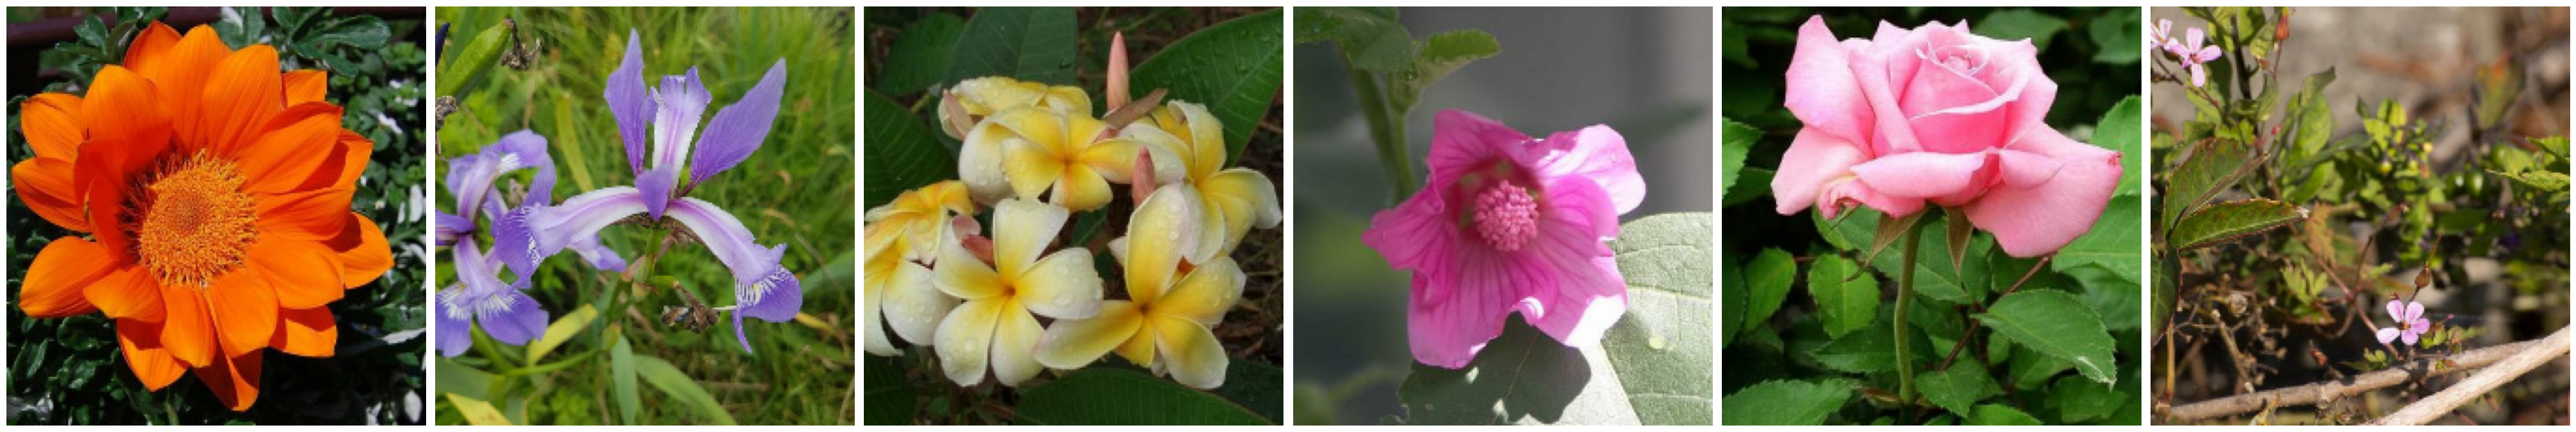

In [5]:
fig, axes = plt.subplots(1, 6, figsize=(40, 20))

train_dataset['image'].head(6)
for i, image in enumerate(train_dataset['image'].head(6)):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

In [6]:
print(f'Train set length: {len(train_dataset)}')
print(f'Validation set length: {len(validation_dataset)}')
print(f'Test set length: {len(test_dataset)}')

Train set length: 12753
Validation set length: 3712
Test set length: 7382


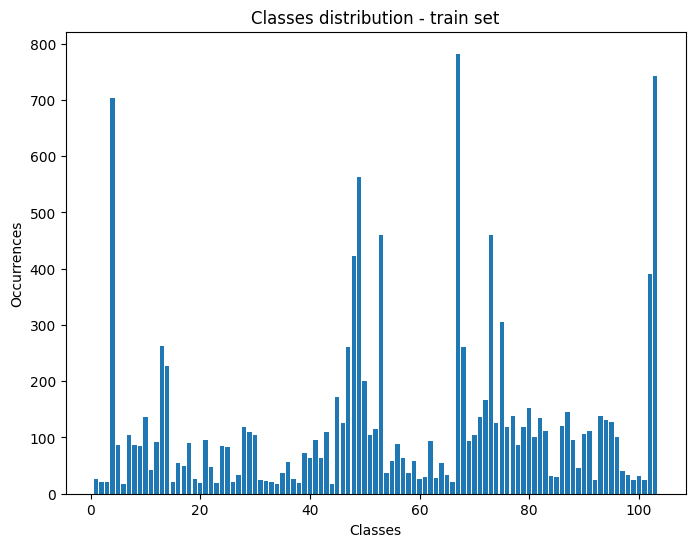

In [7]:
counts = train_dataset['class'].value_counts()
counts.index = [label for label in counts.index]
values = [i for i in range(1, 104)]
occurances = [counts.get(i, 0) for i in range(1, 104)]

plt.figure(figsize=(8, 6))
plt.bar(values, occurances)
plt.xlabel("Classes")
plt.ylabel("Occurrences")
plt.title("Classes distribution - train set")
plt.show()

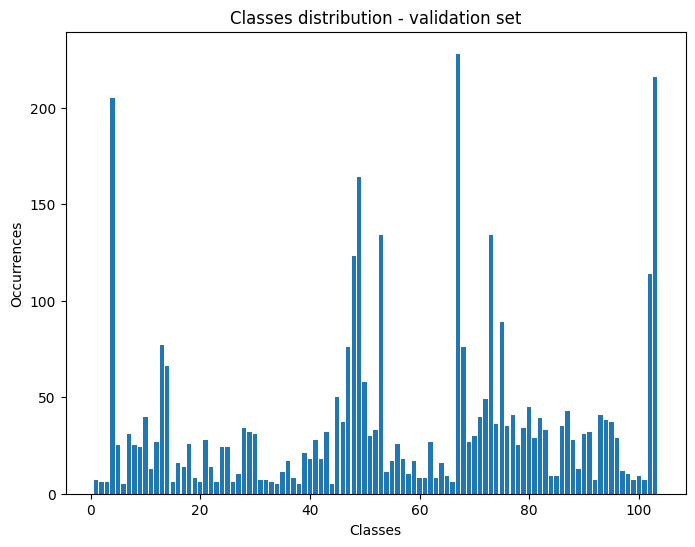

In [8]:
counts = validation_dataset['class'].value_counts()
counts.index = [label for label in counts.index]
values = [i for i in range(1, 104)]
occurances = [counts.get(i, 0) for i in range(1, 104)]

plt.figure(figsize=(8, 6))
plt.bar(values, occurances)
plt.xlabel("Classes")
plt.ylabel("Occurrences")
plt.title("Classes distribution - validation set")
plt.show()

In [9]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=[0.5, 1.5], contrast=[0.8, 1.2], saturation=[0.8, 1.2]),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomCrop(200), 
    transforms.RandomHorizontalFlip(),
])

test_val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class Dataset(Dataset):
    
    def __init__(self, data, transform=None, test=False):
        self.data = data
        self.test = test
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        image = self.data['image'][idx]
        image = Image.fromarray(image)
        image = self.transform(image)
        if not self.test:
            label = self.data['class'][idx]
            label = torch.tensor([1.0 if i == label else 0.0 for i in range(104)]).float()
            return image, label
        else:
            idx = self.data['id'][idx]
            return idx, image
        
train_ds = Dataset(train_dataset, transform=train_transforms)
validation_ds = Dataset(validation_dataset, transform=test_val_transforms)
test_ds = Dataset(test_dataset, test=True, transform=test_val_transforms)

In [10]:
train_dataloader = DataLoader(
    train_ds,
    batch_size = BATCH_SIZE,
)

validation_dataloader = DataLoader(
    validation_ds,
    batch_size = BATCH_SIZE,
)

test_dataloader = DataLoader(
    test_ds,
    batch_size = BATCH_SIZE,
)

In [11]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.base = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
        self.linear1 = torch.nn.Linear(1000, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.5) 
        self.linear2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.linear3 = torch.nn.Linear(256, 128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.dropout3 = torch.nn.Dropout(0.5)
        self.linear4 = torch.nn.Linear(128, 104)
        
    def forward(self, x):
        x = self.base(x)
        x = torch.nn.ReLU()(self.linear1(x)) 
        x = self.bn1(x)
        if self.training:
            x = self.dropout1(x)
        x = torch.nn.ReLU()(self.linear2(x))
        x = self.bn2(x)
        if self.training:
            x = self.dropout2(x)
        x = torch.nn.ReLU()(self.linear3(x))
        x = self.bn3(x)
        if self.training:
            x = self.dropout3(x)
        x = self.linear4(x)
        
        return x

model = Model()

model = model.to(device)
model = torch.nn.DataParallel(model)
# summary(model, (3, 224, 224))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 47.0MB/s]


In [12]:
optimizer = torch.optim.Adam(model.parameters())

In [13]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
criterion =  torch.nn.CrossEntropyLoss()

In [15]:
train_losses = []
validation_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    print('------------------------------------------------')
    print(f'EPOCH: {epoch + 1}/{NUM_EPOCHS}')
    train_loss = 0.0
    validation_loss = 0.0
    
    ### TRAINING
    model.train()
    
    train_correct = 0
    train_samples = 0
    
    for batch_idx, data in enumerate(train_dataloader):    # For each batch in train_dataloader

        image, label = data
        image, label = image.to(device), label.to(device)
        output = model(image)                  # propagate input images forward

        loss = criterion(output, label)        # Loss value for current batch
        train_loss += loss.item()
        
        predicted = torch.max(output, 1)
        label = torch.max(label, 1)
        train_correct += (predicted[1] == label[1]).sum().item()
        train_samples += label[1].size(0)
        
        optimizer.zero_grad()                    # Set all gradients to zero
        
        loss.backward()                        # Compute gradients
        
        optimizer.step()                      # Perform backpropagation
        
    train_loss = train_loss/(batch_idx+1)  
    print(f'Mean train loss: {train_loss}')
    train_losses.append(train_loss)
    
    train_acc = train_correct/train_samples * 100
    print(f'Train accuracy: {train_acc} %')
    print()
    train_accs.append(train_acc)
    
    ### VALIDATION
    model.eval()
    
    val_correct = 0
    val_samples = 0
    
    with torch.no_grad():          # disable gradient calculation, we only want to evaluate model
        for batch_idx, data in enumerate(validation_dataloader): # For each batch in validation_dataloader
            image, label = data
            image, label = image.to(device), label.to(device)
            output = model(image)                           # propagate input images forward
                        
            loss = criterion(output, label)                # And compute loss
            validation_loss += loss.item()
            
            predicted = torch.max(output, 1)
            label = torch.max(label, 1)
            val_correct += (predicted[1] == label[1]).sum().item()
            val_samples += label[1].size(0)

    validation_loss = validation_loss/(batch_idx+1) 
    print(f'Mean validation loss: {validation_loss}')
    validation_losses.append(validation_loss)
    
    val_acc = val_correct/val_samples * 100
    print(f'Validation accuracy: {val_acc} %')
    print('------------------------------------------------')
    val_accs.append(val_acc)
    
    scheduler.step()

------------------------------------------------
EPOCH: 1/30
Mean train loss: 3.8390484762191774
Train accuracy: 20.1442797773073 %

Mean validation loss: 2.4842071851094563
Validation accuracy: 43.696120689655174 %
------------------------------------------------
------------------------------------------------
EPOCH: 2/30
Mean train loss: 2.476747751235962
Train accuracy: 45.7931467105779 %

Mean validation loss: 1.7203783432642619
Validation accuracy: 59.671336206896555 %
------------------------------------------------
------------------------------------------------
EPOCH: 3/30
Mean train loss: 1.8137386226654053
Train accuracy: 58.5979769466008 %

Mean validation loss: 1.22235004901886
Validation accuracy: 71.22844827586206 %
------------------------------------------------
------------------------------------------------
EPOCH: 4/30
Mean train loss: 1.3956844091415406
Train accuracy: 67.61546302830706 %

Mean validation loss: 0.9557257811228435
Validation accuracy: 76.3200431034

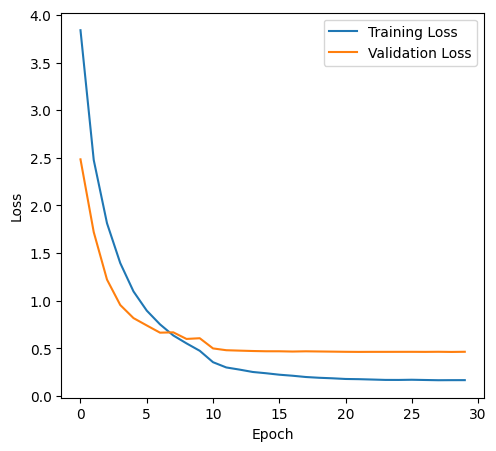

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

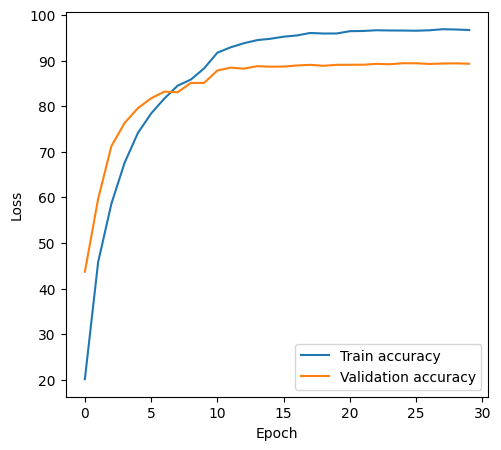

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [18]:
predictions = []
ids = []
for idx, image in test_dataloader:
    image = image.to(device)
    output = model(image)  
    predictions.extend(torch.max(output, 1)[1])   
    ids.extend(idx)

predictions = [x.cpu().numpy() for x in predictions]
    
submission = pd.DataFrame({
    'id': ids,
    'label': predictions
})
submission.to_csv('submission.csv', index=False)
submission

id label
0     59d1b6146    46
1     48c96bd6b    73
2     7b437ba4e     9
3     1b7aef8e8    79
4     d6143b4d4     4
...         ...   ...
7377  2a608c0db   103
7378  d82a21bbd    93
7379  f9c931893    53
7380  18c7b92b8    41
7381  523df966b   102

[7382 rows x 2 columns]